# Sentiment Analysis with an RNN


    | Using an RNN rather than a strictly feedforward network is more accurate since we can include information about the sequence of words.



### Network Architecture¶

The architecture for this network is shown below.

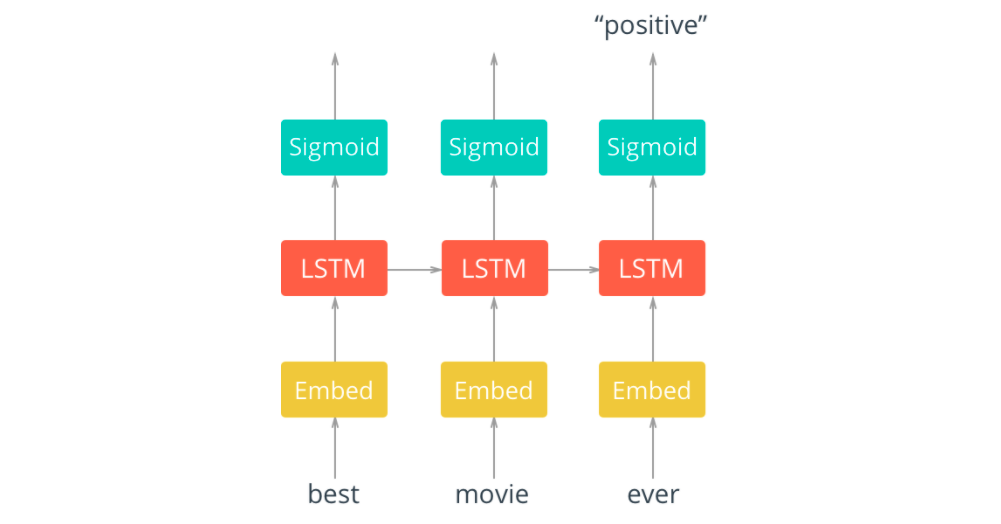

**First, we'll pass in words to an embedding layer.**  We need an embedding layer because we have tens of thousands of words, so we'll need a more efficient representation for our input data than one-hot encoded vectors. You should have seen this before from the Word2Vec lesson. You can actually train an embedding with the Skip-gram Word2Vec model and use those embeddings as input, here. However, it's good enough to just have an embedding layer and let the network learn a different embedding table on its own. In this case, the embedding layer is for dimensionality reduction, rather than for learning semantic representations.

**After input words are passed to an embedding layer, the new embeddings will be passed to LSTM cells.** The LSTM cells will add recurrent connections to the network and give us the ability to include information about the sequence of words in the movie review data.

**Finally, the LSTM outputs will go to a sigmoid output layer.** We're using a sigmoid function because positive and negative = 1 and 0, respectively, and a sigmoid will output predicted, sentiment values between 0-1.

### Pipeline

Data Preprocessing
                        
                        1.Punctuation removing
                                   
                                   |
                                   |
                              2.lowercase 

                                   |
                                   |
                        3.words and labels encoding

                                   |
                                   |
                            4.outlier removing

                                   |
                                   |
                            5.class balancing

                                   |
                                   |
                            6.Sequences Padding
                                   
                                   |
                                   |
                7.Training, Validation, and Testing Set split
                                   
                                   |
                                   |
                        8.DataLoaders and Batching
                
Modelling

                        1.LSTM Layers Settings
                            
                                   |
                                   |
                      2. Instantiate the Network           
                                   
                                   |
                                   |
                              3.Training
                              
                                   |
                                   |
                        4.Testing + Prediction
                        

# 1 Data Preprocessing

## 1.1  Load in and visualize the data¶


In [1]:
import numpy as np

with open("data/reviews.txt","r") as f:
    reviews = f.read()

with open("data/labels.txt","r") as f:
    labels = f.read()
    
print(reviews[:1000])
print()
print(labels[:26])

bromwell high is a cartoon comedy . it ran at the same time as some other programs about school life  such as  teachers  . my   years in the teaching profession lead me to believe that bromwell high  s satire is much closer to reality than is  teachers  . the scramble to survive financially  the insightful students who can see right through their pathetic teachers  pomp  the pettiness of the whole situation  all remind me of the schools i knew and their students . when i saw the episode in which a student repeatedly tried to burn down the school  i immediately recalled . . . . . . . . . at . . . . . . . . . . high . a classic line inspector i  m here to sack one of your teachers . student welcome to bromwell high . i expect that many adults of my age think that bromwell high is far fetched . what a pity that it isn  t   
story of a man who has unnatural feelings for a pig . starts out with a opening scene that is a terrific example of absurd comedy . a formal orchestra audience is turn

## 1.2 Standardize Data

The first step when building a neural network model is getting your data into the proper form to feed into the network. Since we're using embedding layers, we'll need to encode each word with an integer. We'll also want to clean it up a bit.

You can see an example of the reviews data above. Here are the processing steps, we'll want to take:

* We'll want to get rid of periods and extraneous punctuation.
* Also, you might notice that the reviews are delimited with newline characters \n. To deal with those, I'm going to split the text into each review using \n as the delimiter.
* Then I can combined all the reviews back together into one big string.

First, let's remove all punctuation. Then get all the text without the newlines and split it into individual words.

In [2]:
from string import punctuation

reviews = reviews.lower()
all_text = "".join([c for c in reviews if c not in punctuation])

reviews_split = all_text.split("\n")  # split by line
all_text = " ".join(reviews_split)  # recover to a long string

words = all_text.split() # split the long string to single word

words[:30]

['bromwell',
 'high',
 'is',
 'a',
 'cartoon',
 'comedy',
 'it',
 'ran',
 'at',
 'the',
 'same',
 'time',
 'as',
 'some',
 'other',
 'programs',
 'about',
 'school',
 'life',
 'such',
 'as',
 'teachers',
 'my',
 'years',
 'in',
 'the',
 'teaching',
 'profession',
 'lead',
 'me']

## 1.3 Words and Labels encoding 

The embedding lookup requires that we pass in integers to our network. The easiest way to do this is to create dictionaries that map the words in the vocabulary to integers. Then we can convert each of our reviews into integers so they can be passed into the network.

* Exercise: Now you're going to encode the words with integers. Build a dictionary that maps words to integers. Later we're going to pad our input vectors with zeros, so make sure the integers **start at 1, not 0**. Also, convert the reviews to integers and store the reviews in a new list called reviews_ints.

In [3]:
# word encoding

from collections import Counter

counts = Counter(words)  # key --> words, value --> frequency

vocab = sorted(counts, key = counts.get, reverse = True)  # to the word list
vocab_to_int = {word :ii for ii, word in enumerate(vocab,1)}  # starts from index 1, so ii should be larger than 0

reviews_ints = []
for review in reviews_split:
    reviews_ints.append([vocab_to_int[word] for word in review.split()])   # get the representation of each review

In [4]:
# stats about vocabulary
print('Unique words: ', len((vocab_to_int)))  # should ~ 74000+
print()

# print tokens in first review
print('Tokenized review: \n', reviews_ints[:1])

Unique words:  74072

Tokenized review: 
 [[21396, 308, 6, 3, 1050, 207, 8, 2141, 32, 1, 171, 57, 15, 49, 81, 5835, 44, 382, 110, 140, 15, 5216, 60, 154, 9, 1, 5006, 5877, 475, 71, 5, 260, 12, 21396, 308, 13, 1980, 6, 74, 2402, 5, 614, 73, 6, 5216, 1, 25370, 5, 1990, 10172, 1, 5839, 1499, 36, 51, 66, 204, 145, 67, 1204, 5216, 20660, 1, 45313, 4, 1, 221, 883, 31, 2990, 71, 4, 1, 5791, 10, 687, 2, 67, 1499, 54, 10, 216, 1, 384, 9, 62, 3, 1408, 3691, 784, 5, 3498, 180, 1, 382, 10, 1212, 13738, 32, 308, 3, 349, 341, 2913, 10, 143, 127, 5, 7782, 30, 4, 129, 5216, 1408, 2328, 5, 21396, 308, 10, 528, 12, 109, 1449, 4, 60, 543, 102, 12, 21396, 308, 6, 227, 4174, 48, 3, 2213, 12, 8, 215, 23]]


In [5]:
# labels encoding
labels_split = labels.split("\n")   # split by line

encoded_labels = np.array([1 if label == 'positive' else 0 for label in labels_split]) # convert "positive","negative" to 0,1

## 1.4 Outlier Removing

As an additional pre-processing step, we want to make sure that our reviews are in good shape for standard processing. That is, our network will expect a standard input text size, and so, we'll want to shape our reviews into a specific length. We'll approach this task in two main steps:

* Getting rid of extremely long or short reviews; the outliers
* Padding/truncating the remaining data so that we have reviews of the same length.

Before we pad our review text, we should check for reviews of extremely short or long lengths; outliers that may mess with our training.

In [6]:
review_lens = Counter([len(x) for x in reviews_ints])
print("Zero-length reviews: {}".format(review_lens[0]))
print("Maximum review length: {}".format(max(review_lens)))

Zero-length reviews: 1
Maximum review length: 2514


Okay, a couple issues here. We seem to have one review with zero length. And, the maximum review length is way too many steps for our RNN. We'll have to remove any super short reviews and truncate super long reviews. This removes outliers and should allow our model to train more efficiently.

In [7]:
print("Number of reviews before removing outliers: ",len(reviews_ints))

non_zero_idx = [ii for ii, review in enumerate(reviews_ints) if len(review) != 0]  # remove reviews' length =0
reviews_ints = [reviews_ints[ii] for ii in non_zero_idx]    
encoded_labels = np.array([encoded_labels[ii] for ii in non_zero_idx])

print("Number of reviews after removing outliers: ", len(reviews_ints))

Number of reviews before removing outliers:  25001
Number of reviews after removing outliers:  25000


## 1.5 class balancing

In [8]:
zero_number = sum( 1 for i in encoded_labels if i == 0)
non_zero_numbers = sum(1 for i in encoded_labels if i == 1)
print("Zero labels: ", zero_number)
print("Non Zero labels: ",non_zero_numbers)

Zero labels:  12500
Non Zero labels:  12500


The classes are balanced

## 1.6 Padding sequences


To deal with both short and very long reviews, we'll pad or truncate all our reviews to a specific length. For reviews shorter than some seq_length, we'll pad with 0s. For reviews longer than seq_length, we can truncate them to the first seq_length words. A good seq_length, in this case, is 200.

**Exercise**: Define a function that returns an array features that contains the padded data, of a standard size, that we'll pass to the network.

* The data should come from review_ints, since we want to feed integers to the network.
* Each row should be seq_length elements long.
* For reviews shorter than seq_length words, **left pad** with 0s. That is, if the review is ['best', 'movie', 'ever'], [117, 18, 128] as integers, the row will look like [0, 0, 0, ..., 0, 117, 18, 128].
* For reviews longer than seq_length, use only the first seq_length words as the feature vector.

As a small example, if the seq_length=10 and an input review is:

[117, 18, 128]

The resultant, padded sequence should be:

[0, 0, 0, 0, 0, 0, 0, 117, 18, 128]

**The final features array should be a 2D array, with as many rows as there are reviews, and as many columns as the specified seq_length.**

This isn't trivial and there are a bunch of ways to do this. But, if you're going to be building your own deep learning networks, you're going to have to get used to preparing your data.

In [9]:
def pad_features(reviews_ints, seq_length):
    ''' Return features of review_ints, where each review is padded with 0's 
        or truncated to the input seq_length.
    '''
    # getting the correct rows x cols shape
    features = np.zeros((len(reviews_ints), seq_length), dtype = int) # generate (25001,200) 0
    # for each review, I grab that review and 
    for i, row in enumerate(reviews_ints):
        features[i, -len(row):] = np.array(row)[:seq_length]  # if sentence has 140 wors, insert it from position 60
    return features

In [10]:
# Test implementation!

seq_length = 200

features = pad_features(reviews_ints, seq_length=seq_length)

## test statements - do not change - ##
assert len(features)==len(reviews_ints), "Your features should have as many rows as reviews."
assert len(features[0])==seq_length, "Each feature row should contain seq_length values."

# print first 10 values of the first 30 batches 
print(features[:30,:10])

[[    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [23492    42 58310    15   707 17395  3392    47    77    35]
 [ 4538   505    15     3  3344   162  8419  1652     6  4865]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [   54    10    14   116    60   798   552    71   364     5]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    1   330   578    34     3   162   749  2737     9   325]
 [    9    11 10338  5357  1948   690   444    22   280   674]
 [    0     0     0     0     0     0     0     0     0

## 1.7 Training, Validation, Test

With our data in nice shape, we'll split it into training, validation, and test sets.

**Exercise: Create the training, validation, and test sets.**

* You'll need to create sets for the features and the labels, train_x and train_y, for example.
* Define a split fraction, split_frac as the fraction of data to keep in the training set. Usually this is set to 0.8 or 0.9.
* Whatever data is left will be split in half to create the validation and testing data.

In [11]:
nonshuflle_features = features
nonshuffle_labels = encoded_labels

In [12]:
import random
def shuffle_data(features, labels):
    indices = list(range(len(features)))
    random.shuffle(indices)
    features = [features[idx] for idx in indices]
    labels = [labels[idx] for idx in indices]
    return np.array(features), np.array(labels)


In [13]:
features, encoded_labels = shuffle_data(features, encoded_labels)


split_frac = 0.8

split_idx = int(len(features) * split_frac)

train_x, remaining_x = features[:split_idx], features[split_idx:]
train_y, remaining_y = encoded_labels[:split_idx], encoded_labels[split_idx:]

test_idx = int(len(remaining_x)*0.5)
val_x, test_x = remaining_x[:test_idx], remaining_x[test_idx:]
val_y, test_y = remaining_y[:test_idx], remaining_y[test_idx:]

print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(train_x.shape), 
      "\nValidation set: \t{}".format(val_x.shape),
      "\nTest set: \t\t{}".format(test_x.shape))

			Feature Shapes:
Train set: 		(20000, 200) 
Validation set: 	(2500, 200) 
Test set: 		(2500, 200)


## 1.8 DataLoaders and Batching


After creating training, test, and validation data, we can create DataLoaders for this data by following two steps:

* Create a known format for accessing our data, using TensorDataset which takes in an input set of data and a target set of data with the same first dimension, and creates a dataset.
* Create DataLoaders and batch our training, validation, and test Tensor datasets.
    
    train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
    
    train_loader = DataLoader(train_data, batch_size=batch_size)

This is an alternative to creating a generator function for batching our data into full batches.

In [14]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

# dataloaders
batch_size = 50

# make sure the SHUFFLE your training data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [15]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([50, 200])
Sample input: 
 tensor([[    0,     0,     0,  ...,     5,    66,     8],
        [   10,    68,   547,  ...,    12,    10,   547],
        [ 1225,  4952,    13,  ...,  1484,  5004,     2],
        ...,
        [    0,     0,     0,  ...,   201,     8,     3],
        [  602,   112,  1011,  ...,    48,  9929,  4150],
        [  751,    23,   108,  ...,  2684,    56, 37645]])

Sample label size:  torch.Size([50])
Sample label: 
 tensor([1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
        0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1,
        0, 1])


# 2 Sentiment Network with PyTorch

Below is where you'll define the network.


The layers are as follows:

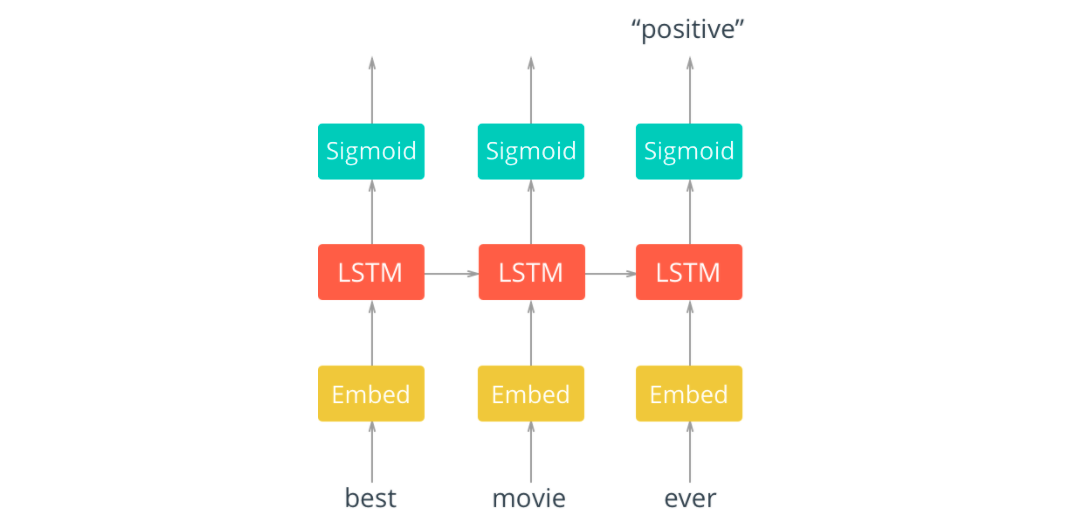

1. An embedding layer that converts our word tokens (integers) into embeddings of a specific size.

2. An LSTM layer defined by a hidden_state size and number of layers

3. A fully-connected output layer that maps the LSTM layer outputs to a desired output_size

4. A sigmoid activation layer which turns all outputs into a value 0-1; return only the last sigmoid output as the output of this network.

**The Embedding Layer**

We need to add an embedding layer because there are 74000+ words in our vocabulary. It is massively inefficient to one-hot encode that many classes. So, instead of one-hot encoding, we can have an embedding layer and use that layer as a lookup table. You could train an embedding layer using Word2Vec, then load it here. But, it's fine to just make a new layer, using it for only dimensionality reduction, and let the network learn the weights.



## 2.1 The LSTM Layer(s)
We'll create an LSTM to use in our recurrent network, which takes in an input_size, a hidden_dim, a number of layers, a dropout probability (for dropout between multiple layers), and a batch_first parameter.

Most of the time, you're network will have better performance with more layers; between 2-3. Adding more layers allows the network to learn really complex relationships.

Note: init_hidden should initialize the hidden and cell state of an lstm layer to all zeros, and move those state to GPU, if available.

In [16]:
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')

No GPU available, training on CPU.


In [17]:
import torch.nn as nn

class SentimentRNN(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """

    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        """
        Initialize the model by setting up the layers.
        """
        super(SentimentRNN, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, 
                            dropout=drop_prob, batch_first=True)
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
        
        # linear and sigmoid layers
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sig = nn.Sigmoid()
        

    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)

        # embeddings and lstm_out
        x = x.long()
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
    
        # stack up lstm outputs
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        # dropout and fully-connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
    
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden

## 2.2 Instantiate the network

ere, we'll instantiate the network. First up, defining the hyperparameters.

* vocab_size: Size of our vocabulary or the range of values for our input, word tokens.
* output_size: Size of our desired output; the number of class scores we want to output (pos/neg).
* embedding_dim: Number of columns in the embedding lookup table; size of our embeddings.
* hidden_dim: Number of units in the hidden layers of our LSTM cells. Usually larger is better performance wise. Common values are 128, 256, 512, etc.
* n_layers: Number of LSTM layers in the network. Typically between 1-3


In [18]:
# Instantiate the model w/ hyperparams
vocab_size = len(vocab_to_int)+1 # +1 for the 0 padding + our word tokens
output_size = 1
embedding_dim = 400
hidden_dim = 256
n_layers = 2

net = SentimentRNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)

print(net)


SentimentRNN(
  (embedding): Embedding(74073, 400)
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


## 2.3 Training

Below is the typical training code. If you want to do this yourself, feel free to delete all this code and implement it yourself. You can also add code to save a model by name.

We'll also be using a new kind of cross entropy loss, which is designed to work with a single Sigmoid output. BCELoss, or Binary Cross Entropy Loss, applies cross entropy loss to a single value between 0 and 1.

We also have some data and training hyparameters:

* lr: Learning rate for our optimizer.
* epochs: Number of times to iterate through the training dataset.
* clip: The maximum gradient value to clip at (to prevent exploding gradients).

In [19]:
# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

In [20]:
# training params

epochs = 4 # 3-4 is approx where I noticed the validation loss stop decreasing

counter = 0
print_every = 100
clip=5 # gradient clipping

# move model to GPU, if available
if(train_on_gpu):
    net.cuda()

net.train()
# train for some number of epochs
for e in range(epochs):
    # initialize hidden state
    h = net.init_hidden(batch_size)

    # batch loop
    for inputs, labels in train_loader:
        counter += 1

        if(train_on_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        # zero accumulated gradients
        net.zero_grad()

        # get the output from the model
        output, h = net(inputs, h)

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()

        # loss stats
        if counter % print_every == 0:
            # Get validation loss
            val_h = net.init_hidden(batch_size)
            val_losses = []
            net.eval()
            for inputs, labels in valid_loader:

                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history
                val_h = tuple([each.data for each in val_h])

                if(train_on_gpu):
                    inputs, labels = inputs.cuda(), labels.cuda()

                output, val_h = net(inputs, val_h)
                val_loss = criterion(output.squeeze(), labels.float())

                val_losses.append(val_loss.item())

            net.train()
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))

Epoch: 1/4... Step: 100... Loss: 0.685736... Val Loss: 0.656841
Epoch: 1/4... Step: 200... Loss: 0.613204... Val Loss: 0.624079
Epoch: 1/4... Step: 300... Loss: 0.573525... Val Loss: 0.644771
Epoch: 1/4... Step: 400... Loss: 0.538187... Val Loss: 0.526687
Epoch: 2/4... Step: 500... Loss: 0.412967... Val Loss: 0.522549
Epoch: 2/4... Step: 600... Loss: 0.364186... Val Loss: 0.458034
Epoch: 2/4... Step: 700... Loss: 0.497118... Val Loss: 0.501595
Epoch: 2/4... Step: 800... Loss: 0.385709... Val Loss: 0.483902
Epoch: 3/4... Step: 900... Loss: 0.309134... Val Loss: 0.441744
Epoch: 3/4... Step: 1000... Loss: 0.453563... Val Loss: 0.425027
Epoch: 3/4... Step: 1100... Loss: 0.344417... Val Loss: 0.404660
Epoch: 3/4... Step: 1200... Loss: 0.262536... Val Loss: 0.434908
Epoch: 4/4... Step: 1300... Loss: 0.226480... Val Loss: 0.472245
Epoch: 4/4... Step: 1400... Loss: 0.129020... Val Loss: 0.443041
Epoch: 4/4... Step: 1500... Loss: 0.410320... Val Loss: 0.487647
Epoch: 4/4... Step: 1600... Loss: 

# 2.4 Testing


There are a few ways to test network.

* **Test data performance**: First, we'll see how our trained model performs on all of our defined test_data, above. We'll calculate the average loss and accuracy over the test data.

* **Inference on user-generated data**: Second, we'll see if we can input just one example review at a time (without a label), and see what the trained model predicts. Looking at new, user input data like this, and predicting an output label, is called inference.

In [21]:
# Get test data loss and accuracy

test_losses = [] # track loss
num_correct = 0

# init hidden state
h = net.init_hidden(batch_size)

net.eval()
# iterate over test data
for inputs, labels in test_loader:

    # Creating new variables for the hidden state, otherwise
    # we'd backprop through the entire training history
    h = tuple([each.data for each in h])

    if(train_on_gpu):
        inputs, labels = inputs.cuda(), labels.cuda()
    
    # get predicted outputs
    output, h = net(inputs, h)
    
    # calculate loss
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())
    
    # convert output probabilities to predicted class (0 or 1)
    pred = torch.round(output.squeeze())  # rounds to the nearest integer
    
    # compare predictions to true label
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)


# -- stats! -- ##
# avg test loss
print("Test loss: {:.3f}".format(np.mean(test_losses)))

# accuracy over all test data
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}".format(test_acc))

Test loss: 0.451
Test accuracy: 0.828


### Prediction

We can change this test_review to any text that you want. Read it and think: is it pos or neg? Then see if your model predicts correctly!


* We can use any functions that you've already defined or define any helper functions you want to complete predict, but it should just take in a trained net, a text review, and a sequence length.

In [22]:
# negative test review
test_review_neg = 'The worst movie I have seen; acting was terrible and I want my money back. This movie had bad acting and the dialogue was slow.'

from string import punctuation

def tokenize_review(test_review):
    test_review = test_review.lower() # lowercase
    # get rid of punctuation
    test_text = ''.join([c for c in test_review if c not in punctuation])

    # splitting by spaces
    test_words = test_text.split()

    # tokens
    test_ints = []
    test_ints.append([vocab_to_int[word] for word in test_words])

    return test_ints

# test code and generate tokenized review
test_ints = tokenize_review(test_review_neg)
print(test_ints)

[[1, 247, 18, 10, 28, 108, 113, 14, 388, 2, 10, 181, 60, 274, 144, 11, 18, 68, 76, 113, 2, 1, 410, 14, 539]]


In [23]:
# test sequence padding
seq_length=200
features = pad_features(test_ints, seq_length)

print(features)

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   1 247  18  10  28
  108 113  14 388   2  10 181  60 274 144  11  18  68  76 113   2   1 410
   14 539]]


In [24]:
# test conversion to tensor and pass into your model
feature_tensor = torch.from_numpy(features)
print(feature_tensor.size())

torch.Size([1, 200])


In [25]:
def predict(net, test_review, sequence_length=200):
    
    net.eval()
    
    # tokenize review
    test_ints = tokenize_review(test_review)
    
    # pad tokenized sequence
    seq_length=sequence_length
    features = pad_features(test_ints, seq_length)
    
    # convert to tensor to pass into your model
    feature_tensor = torch.from_numpy(features)
    
    batch_size = feature_tensor.size(0)
    
    # initialize hidden state
    h = net.init_hidden(batch_size)
    
    if(train_on_gpu):
        feature_tensor = feature_tensor.cuda()
    
    # get the output from the model
    output, h = net(feature_tensor, h)
    
    # convert output probabilities to predicted class (0 or 1)
    pred = torch.round(output.squeeze()) 
    # printing output value, before rounding
    print('Prediction value, pre-rounding: {:.6f}'.format(output.item()))
    
    # print custom response
    if(pred.item()==1):
        print("Positive review detected!")
    else:
        print("Negative review detected.")

In [26]:
# positive test review
test_review_pos = 'This movie had the best acting and the dialogue was so good. I loved it.'

In [27]:
# call function
seq_length=200 # good to use the length that was trained on

predict(net, test_review_neg, seq_length)

Prediction value, pre-rounding: 0.013002
Negative review detected.
